# Data Analysis File

This file contains all the data analysis including all explanations, calculations, and code.

## Packages Used

In [221]:
import csv
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display,HTML
from PIL import Image

## Before We Begin...

Before we get started on the analysis, there are some terms and conditions I would like to discuss:

<u>General Terminology</u>
* ``P-value`` = "the probability of observing the data assuming the null hypothesis is true, helping to determine the strength of the evidence against the null hypothesis" ([geeksforgeeks](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/)). The closer to 0 the p-value is, the [stronger the evidence against the null hypothesis](https://www.geo.fu-berlin.de/en/v/soga-r/Basics-of-statistics/Hypothesis-Tests/Introduction-to-Hypothesis-Testing/Critical-Value-and-the-p-Value-Approach/index.html#:~:text=The%20smaller%20(closer%20to%200,null%20hypothesis%20is%20not%20rejected.).
* ``Null hypothesis`` = "a general statistical statement or assumption about a population parameter that is assumed to be true Until we have sufficient evidence to reject it. It is generally denoted by Ho"([geeksforgeeks](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/)).
* ``Alternate hypothesis`` = "considered as competing of the null hypothesis. It is generally denoted by H1 . The general goal of our hypothesis testing is to test the Alternative hypothesis against the null hypothesis" ([geeksforgeeks](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/)).

<u>General Conditions</u>
* The ``null hypothesis`` for this study is that there _is no significant relation_ between the given factor and social media's influence on the consumer's purchase.
* The ``alternative hypothesis`` for this study is that there _is a significant relation_ between the given factor and social media's influence on the consumer's purchase.
* Based on [current practices](https://passel2.unl.edu/view/lesson/9beaa382bf7e/8), I will be using an alpha value of 5.0% ``(p < 0.05)`` to determine if observed deviations are significant.

__Chi-Square Test of Independence__

<u>Terminology</u>
* ``Observed values`` = the actual data in the dataset
* ``Expected values`` = the frequencies you'd anticipate seeing in each category if the null hypothesis is true

<u>Conditions</u>
* [An observed value can be zero](https://www.theanalysisfactor.com/observed-values-less-than-5-in-a-chi-square-test-no-biggie/) as long as the expected value for that cell is not zero. An expected value of zero can lead to undefined calculations.
* There must be an [expected value of at least 5](https://www.jmp.com/en_us/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html) for each combination of variables, otherwise the test results are unreliable.
* ``Expected values`` are calculated using this [function](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/): (row total * column total) / grand total
* If chi-square calculated value > chi-square critical value, then the [null hypothesis is rejected](https://passel2.unl.edu/view/lesson/9beaa382bf7e/8#:~:text=If%20your%20chi%2Dsquare%20calculated,to%20reject%22%20your%20null%20hypothesis.).

Now let's convert the dataset csv file into a list of dictionaries.

In [222]:
consumer_data = []
with open('social_media_dataset.csv') as f:
    consumer_data = [{k: str(v) for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True)]
print(consumer_data[0])

{'\ufeffConsumer ID': '1', 'Customer Name': 'Alice Johnson', 'Age': '28', 'Gender': 'Female', 'Income (USD)': '45000', 'Education Level': "Bachelor's", 'Social Media Usage (Hours/Day)': '2.5', 'Social Media Platforms': 'Instagram, Twitter', 'Influence Level': 'Very Influential', 'Purchase Decision': 'Yes', 'Product Category': 'Fashion', 'Specific Product': 'Dress', 'Amount Spent (USD)': '200', 'Brand Name': 'Nike, Zara', 'City': 'New York'}


## Dataset sanity check

The data card on Kaggle for this dataset says ``Consumer ID`` is a unique identifier for each consumer. Let's check if that is true. While we do this, let's also check how many consumers are in this dataset.

In [223]:
def determine_id_dupes():
    set_of_ids = set()
    found_a_dupe = False
    consumer_total = 0

    for consumer in consumer_data:
        consumer_total = consumer_total + 1
        if consumer['\ufeffConsumer ID'] in set_of_ids:
            found_a_dupe = True
        else:
            set_of_ids.add(consumer['\ufeffConsumer ID'])
            
    return found_a_dupe, consumer_total

In [224]:
# Call determine_id_dupes to check for duplicates of IDs in the list
has_dupes, consumer_total = determine_id_dupes()

#if this prints 'True', that means we found at least one duplicate ID
print(has_dupes)
print(consumer_total)

False
300


Good, there are no duplicated IDs and there are 300 consumers in the dataset. With that checked let's move on to the analysis.

## RQ1: What demographic is most/least affected by social media in purchase decision-making?

What demographic factors are influenced by social media in purchase decision-making?

I will be analyzing four different demographic factors:
1. Age: age of consumer
2. Gender: gender of consumer
3. Income: annual income of consumer in USD
4. Education level: highest level of education attained by the consumer (e.g., Bachelor's, Master's, PhD, High School)

_Note: The factor descriptions are from the dataset's data card on [Kaggle](https://www.kaggle.com/datasets/lastman0800/impact-of-social-media-dataset/data)._

### Factor 1: Age

* ``Null Hypothesis``: Age and social media's influence on a purchase are independent.
* ``Alternative Hypothesis``: Age and social media's influence on a purchase are not independent.

First, I will determine the range of ages present in the dataset.

In [225]:
youngest = 90000 # youngest age of recorded consumers
oldest = -1 # oldest age of recorded consumers

for consumer in consumer_data:
    if int(consumer['Age']) < youngest:
        youngest = int(consumer['Age'])
    elif int(consumer['Age']) > oldest:
        oldest = int(consumer['Age'])
    else:
        pass

print(youngest)
print(oldest)

22
45


Based on the 22 to 45 age range, I will be grouping the ages in 2 ranges of 11 years (22-33 and 34-45). I will now calculate the totals of each range and how many in each range were influenced or not influenced by social media for a purchase.

In [226]:
young_influenced = 0 # consumers ages 22-33 whose purchases were influenced by social media
young_uninfluenced = 0 # consumers ages 22-33 not influenced by social media

old_influenced = 0 # consumers aged 34-45 whose purchases were influenced by social media
old_uninfluenced = 0 # consumers aged 34-45 whose purchases were not influenced by social media

for consumer in consumer_data:
    if int(consumer['Age']) <= 33: # consumer's age is less than or equal to 33
        if consumer['Purchase Decision'] == 'Yes':
            young_influenced = young_influenced + 1
        else:
            young_uninfluenced = young_uninfluenced + 1
    else: # consumer is older than 33
        if consumer['Purchase Decision'] == 'Yes':
            old_influenced = old_influenced + 1
            old_uninfluenced = old_uninfluenced + 1

young_total = young_influenced + young_uninfluenced
old_total = old_influenced + old_uninfluenced

age_influenced_total = young_influenced + old_influenced
age_uninfluenced_total = young_uninfluenced + old_uninfluenced

In [227]:
with open('observed_age_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow((' ', 'ages 22-33', 'ages 34-45', 'row totals'))
    
    writer.writerow(('influenced', young_influenced, old_influenced, age_influenced_total))
    writer.writerow(('not influenced', young_uninfluenced, old_uninfluenced, age_uninfluenced_total))
    writer.writerow(('column totals', young_total, old_total, consumer_total))

In [228]:
observed_age_plot = pd.read_csv('observed_age_table.csv')
observed_age_plot

,,ages 22-33,ages 34-45,row totals
0,influenced,254,32,286
1,not influenced,14,32,46
2,column totals,268,64,300


Looking at the row and column totals, there are no combinations where the expected value is less than 5. With that in mind, I will use the chi-square test of independence using the ``chi2_contingency`` function from the ``scipy.stats`` package. 

In [229]:
# defining the table
obs_age_data = [[young_influenced, old_influenced], [young_uninfluenced, old_uninfluenced]]

# age_test_stat = test statistic aka the chi-square value
# age_p_val = p-value of the test
# age_dof = degrees of freedom
# age_expected_freq = expected frequencies, based on the marginal sums of the table
age_test_stat, age_p_val, age_dof, age_expected_freq = chi2_contingency(obs_age_data)

# display results
print('chi-square statistic: ' + str(age_test_stat))
print('degrees of freedom: ' + str(age_dof))
print('expected values:' + str(age_expected_freq))

# interpret p-value
alpha = 0.05
print("p value is " + str(age_p_val))
if age_p_val <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

chi-square statistic: 83.06954512270663
degrees of freedom: 1
expected values:[[230.86746988  55.13253012]
 [ 37.13253012   8.86746988]]
p value is 7.921679253072971e-20
Dependent (reject H0)


__Insight from chi-square test__:

Since our p-value is less than our alpha (0.05), we reject the null hypothesis that age and social media influence has no significant relation. We can assume the differences between the expected and observed values could not be due to mere chance. 

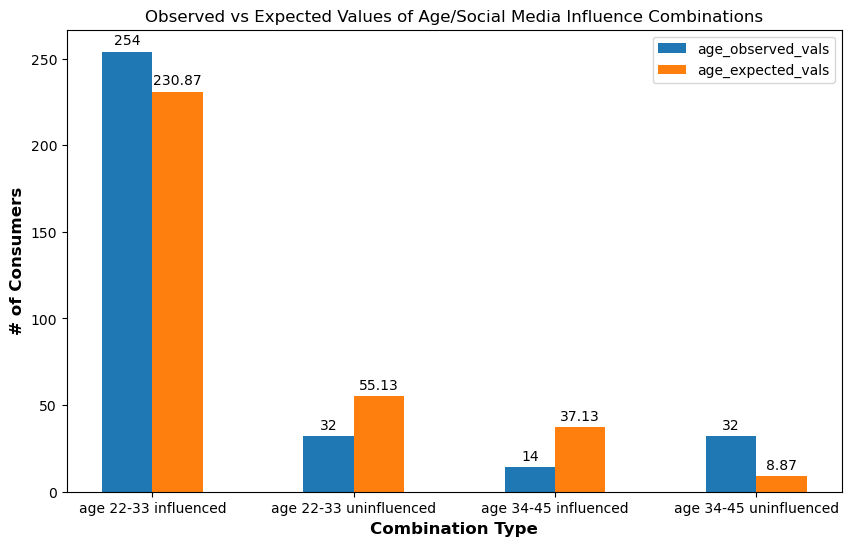

In [230]:
age_combos = ('age 22-33 influenced', 'age 34-45 influenced', 'age 22-33 uninfluenced', 'age 34-45 uninfluenced')
age_vals = {
    'age_observed_vals': (obs_age_data[0][0], obs_age_data[0][1], obs_age_data[1][0], obs_age_data[1][1]),
    'age_expected_vals': (round(age_expected_freq[0][0], 2), round(age_expected_freq[0][1], 2), 
                          round(age_expected_freq[1][0], 2), round(age_expected_freq[1][1], 2))
}


x = np.arange(len(age_combos))  # the label locations
multiplier = 0

barWidth = 0.25
fig = plt.subplots(figsize =(10, 6)) 

for attribute, measurement in age_vals.items():
    offset = barWidth * multiplier
    rects = plt.bar(x + offset, measurement, barWidth, label=attribute)
    plt.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Observed vs Expected Values of Age/Social Media Influence Combinations')
plt.xlabel('Combination Type', fontweight ='bold', fontsize = 12) 
plt.ylabel('# of Consumers', fontweight ='bold', fontsize = 12) 
plt.xticks([r + (barWidth / 2) for r in range(len(age_vals['age_observed_vals']))], 
        ['age 22-33 influenced', 'age 22-33 uninfluenced', 'age 34-45 influenced', 'age 34-45 uninfluenced'])

plt.legend()
plt.show()

__Insights from observed vs expected values__:
* More consumers than expected aged 22-33 completed a purchase influenced by social media.
* Fewer consumers than expected aged 22-23 were uninfluenced by social media during their purchase.
* Fewer consumers than expected aged 34-45 completed a purchase influenced by social media.
* More consumers than expected aged 34-45 were uninfluenced by social media during their purchase.

### Factor 2: Gender

* ``Null Hypothesis``: Gender and social media's influence on a purchase are independent.
* ``Alternative Hypothesis``: Gender and social media's influence on a purchase are not independent.

First, I want to check if there are other genders recorded in the demographic data besides ``male`` and ``female``. That way, I know the different gender labels in the data set.

In [231]:
# Loop through each consumer in the consumer_data dataset
for consumer in consumer_data:
    # print out consumer data of person if they do not identify as male or female
    if consumer['Gender'].lower() != 'female' and consumer['Gender'].lower() != 'male':
        print(consumer) 
    else:
        pass

{'\ufeffConsumer ID': '3', 'Customer Name': 'Chris Taylor', 'Age': '22', 'Gender': 'Non-binary', 'Income (USD)': '32000', 'Education Level': 'High School', 'Social Media Usage (Hours/Day)': '4', 'Social Media Platforms': 'TikTok, Snapchat', 'Influence Level': 'Not Influential', 'Purchase Decision': 'No', 'Product Category': 'N/A', 'Specific Product': 'N/A', 'Amount Spent (USD)': '0', 'Brand Name': 'N/A', 'City': 'Chicago'}


It looks like there is a consumer who identifies as ``non-binary``. Now let's calculate the totals of every combination of male/female/non-binary and influenced/not influenced.

In [232]:
# The first two indexes of gender_arr are for female consumers who were influenced by social media (index 0) and 
# who were not (index 1). The second two indexes are for male consumers who were influenced by social media
# (index 2) and who were not (index 3). This pattern continues for the third grouping of nonbinary consumers.
gender_observed_arr = [0, 0, 0, 0, 0, 0]

for consumer in consumer_data:
    if consumer['Gender'].lower() == 'female':
        if consumer['Purchase Decision'].lower() == 'yes':
            gender_observed_arr[0] = gender_observed_arr[0] + 1
        else:
            gender_observed_arr[1] = gender_observed_arr[1] + 1
    elif consumer['Gender'].lower() == 'male':
        if consumer['Purchase Decision'].lower() == 'yes':
            gender_observed_arr[2] = gender_observed_arr[2] + 1
        else:
            gender_observed_arr[3] = gender_observed_arr[3] + 1
    else:
        if consumer['Purchase Decision'].lower() == 'yes':
            gender_observed_arr[4] = gender_observed_arr[4] + 1
        else:
            gender_observed_arr[5] = gender_observed_arr[5] + 1

female_total = gender_observed_arr[0] + gender_observed_arr[1]
male_total = gender_observed_arr[2] + gender_observed_arr[3]
nonbinary_total = gender_observed_arr[4] + gender_observed_arr[5]

gender_influenced_total = gender_observed_arr[0] + gender_observed_arr[2] + gender_observed_arr[4]
gender_uninfluenced_total = gender_observed_arr[1] + gender_observed_arr[3] + gender_observed_arr[5]

print(gender_observed_arr)

[137, 12, 149, 1, 0, 1]


In [233]:
with open('observed_gender_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(('female', 'male', 'non-binary', 'row totals'))
    
    writer.writerow(('influenced', gender_observed_arr[0], gender_observed_arr[2], gender_observed_arr[4], gender_influenced_total))
    writer.writerow(('not influenced', gender_observed_arr[1], gender_observed_arr[3], gender_observed_arr[5], gender_uninfluenced_total))
    writer.writerow(('column totals', female_total, male_total, nonbinary_total, consumer_total))

In [234]:
observed_gender_plot = pd.read_csv('observed_gender_table.csv')
observed_gender_plot

,female,male,non-binary,row totals
influenced,137,149,0,286
not influenced,12,1,1,14
column totals,149,150,1,300


In this situation I cannot use the chi-square test because the non-binary consumer ``row total`` multipled by the ``not influenced`` column total divided by the ``grand total`` is less than five for the expected values. 

As a result, I will not be including the ``non-binary`` consumer so I can use the chi-square test with a male/female and influenced/not influenced contingency table. I also reason that this data point is "ok" to remove since it is the only non-binary instance recorded and therefore not representative of the greater population being studied.

The revised contingency table is as follows:

In [235]:
revised_gender_influenced_total = gender_observed_arr[0] + gender_observed_arr[2] 
revised_gender_uninfluenced_total = gender_observed_arr[1] + gender_observed_arr[3]

revised_consumer_total = revised_gender_influenced_total + revised_gender_uninfluenced_total

In [236]:
with open('revised_observed_gender_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(('female', 'male', 'row totals'))
    
    writer.writerow(('influenced', gender_observed_arr[0], gender_observed_arr[2], revised_gender_influenced_total))
    writer.writerow(('not influenced', gender_observed_arr[1], gender_observed_arr[3], revised_gender_uninfluenced_total))
    writer.writerow(('column totals', female_total, male_total, revised_consumer_total))

In [237]:
observed_gender_plot = pd.read_csv('revised_observed_gender_table.csv')
observed_gender_plot

,female,male,row totals
influenced,137,149,286
not influenced,12,1,13
column totals,149,150,299


In [238]:
# defining the table
obs_gender_data = [[gender_observed_arr[0], gender_observed_arr[2]], # influenced female, influenced male
                   [gender_observed_arr[1], gender_observed_arr[3]]] # uninfluenced female, uninfluenced male

# gender_test_stat = test statistic aka the chi-square value
# gender_p_val = p-value of the test
# gender_dof = degrees of freedom
# gender_expected_freq = expected frequencies, based on the marginal sums of the table
gender_test_stat, gender_p_val, gender_dof, gender_expected_freq = chi2_contingency(obs_gender_data)

# display results
print('chi-square statistic: ' + str(gender_test_stat))
print('degrees of freedom: ' + str(gender_dof))
print('expected values:' + str(gender_expected_freq))

# interpret p-value
alpha = 0.05
print("p value is " + str(gender_p_val))
if gender_p_val <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

chi-square statistic: 8.11213087248322
degrees of freedom: 1
expected values:[[142.52173913 143.47826087]
 [  6.47826087   6.52173913]]
p value is 0.004397000976185477
Dependent (reject H0)


__Insight from chi-square test__:

Since our p-value is less than our alpha (0.05), we reject the null hypothesis that gender and social media influence has no significant relation. We can assume the differences between the expected and observed values could not be due to mere chance. 

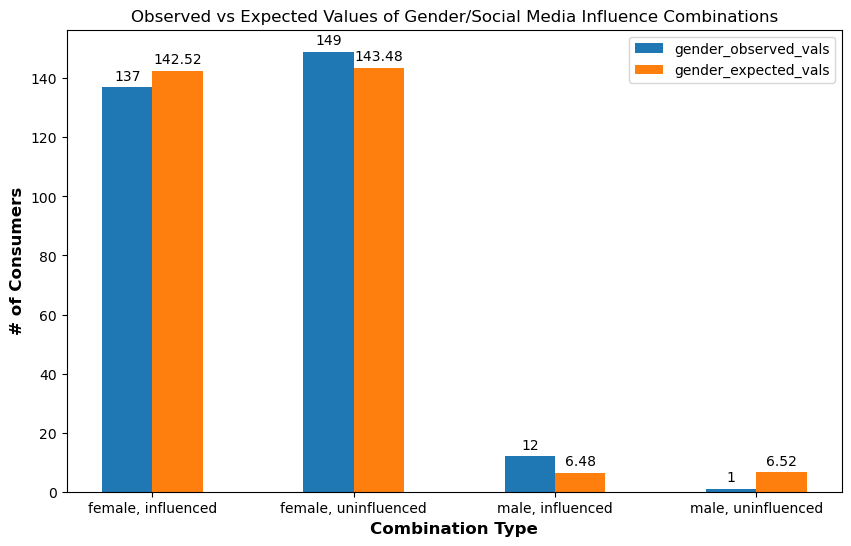

In [239]:
combos = ('female, influenced', 'male, influenced', 'female, uninfluenced', 'male, uninfluenced')
gender_vals = {
    'gender_observed_vals': (obs_gender_data[0][0], obs_gender_data[0][1], # female/influenced, male/influenced
                          obs_gender_data[1][0], obs_gender_data[1][1]), # female/uninfluenced, male/uninfluenced
    'gender_expected_vals': (round(gender_expected_freq[0][0], 2), round(gender_expected_freq[0][1], 2), # female/influenced, male/influenced
                          round(gender_expected_freq[1][0], 2), round(gender_expected_freq[1][1], 2)) # female/uninfluenced, male/uninfluenced
}

x = np.arange(len(combos))  # the label locations
multiplier = 0

# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6)) 

# Add counts display for each bar
for attribute, measurement in gender_vals.items():
    offset = barWidth * multiplier
    rects = plt.bar(x + offset, measurement, barWidth, label=attribute)
    plt.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Observed vs Expected Values of Gender/Social Media Influence Combinations')
plt.xlabel('Combination Type', fontweight ='bold', fontsize = 12) 
plt.ylabel('# of Consumers', fontweight ='bold', fontsize = 12) 
plt.xticks([r + (barWidth / 2) for r in range(len(gender_vals['gender_observed_vals']))], 
           ['female, influenced', 'female, uninfluenced', 'male, influenced', 'male, uninfluenced'])

plt.legend()
plt.show()

__Insights from observed vs expected values__:
* Slightly less female consumers than expected completed a purchase influenced by social media.
* Slightly more female consumers than expected were uninfluenced by social media during their purchase.
* More male consumers than expected completed a purchase influenced by social media.
* Fewer male consumers than expected were uninfluenced by social media during their purchase.

### Factor 3: Income

* ``Null Hypothesis``: Income and social media's influence on a purchase are independent.
* ``Alternative Hypothesis``: Income and social media's influence on a purchase are not independent.

First, I will determine the range of incomes in the dataset.

In [240]:
lowest_income = -1 # lowest income level in dataset
highest_income = -1 # highest income level in dataset

for consumer in consumer_data:
    curr_income = int(consumer['Income (USD)']) # convert string into int
    
    if lowest_income == -1:
        lowest_income = curr_income
    else:
        if curr_income < lowest_income:
            lowest_income = curr_income
        elif curr_income > highest_income:
            highest_income = curr_income
        else:
            pass

print(lowest_income)
print(highest_income)

32000
80000


I will be grouping income levels in the dataset based on [2022 US Census Bureau](https://www.census.gov/content/dam/Census/library/publications/2023/demo/p60-279.pdf) household income data and [Yahoo!Finance's](https://finance.yahoo.com/news/income-fall-americas-lower-middle-122100515.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAM6H35XwcgpCtSdjGKClh_A4Xn4KgA5u5USDoU498z-05vA5t7BvBlIZCrK3yCAJdVJ6baLY6QpOCoTlzevd_009j3xKVKC_fJcDvLe0qGdFohdOBI9_RxlE7DxOqaF9AwzM2ByIo00zFpXhuiTSKDjakxxlAJ14DBXJhf6BjbTb) income groupings and associated class labels:

* ``Lower class``: up to \$30,000
* ``Lower-middle class``: \\$30,001 - \$58,020
* ``Middle class``: \\$58,021 - \$94,000
* ``Upper-middle class``: \\$94,001 - \$153,000
* ``Upper class``: over \$153,000

Based on the lowest and highest income levels in the dataset, I will be splitting up the incomes into a ``lower-middle class`` group and a ``middle-class`` group. In this process, I will also be determining the counts for how many consumers in each class group reported being influenced by social media during a purchase or not.

In [241]:
low_mid_influenced = 0 # lower-middle class & influenced
low_mid_uninfluenced = 0 # lower-middle class & uninfluenced

mid_influenced = 0 # middle class & influenced
mid_uninfluenced = 0 # middle class & uninfluenced

for consumer in consumer_data:
    curr_income = int(consumer['Income (USD)']) # convert string into int
    if curr_income <= 58020:
        if consumer['Purchase Decision'] == 'Yes': # lower-middle class & influenced
            low_mid_influenced = low_mid_influenced + 1
        else:
            low_mid_uninfluenced = low_mid_uninfluenced + 1
    else:
        if consumer['Purchase Decision'] == 'Yes': # middle class & influenced
            mid_influenced = mid_influenced + 1
        else:
            mid_uninfluenced = mid_uninfluenced + 1

# row totals for table display
income_influenced_total = low_mid_influenced + mid_influenced
income_uninfluenced_total = low_mid_uninfluenced + mid_uninfluenced

# column totals for table display
income_low_mid_total = low_mid_influenced + low_mid_uninfluenced
income_mid_total = mid_influenced + mid_uninfluenced

In [242]:
with open('observed_income_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(('lower-middle class', 'middle class', 'row totals'))
    
    writer.writerow(('influenced', low_mid_influenced, mid_influenced, income_influenced_total))
    writer.writerow(('not influenced', low_mid_uninfluenced, mid_uninfluenced, income_uninfluenced_total))
    writer.writerow(('column totals', income_low_mid_total, income_mid_total, consumer_total))

In [243]:
# import pandas as pd
observed_gender_plot = pd.read_csv('observed_income_table.csv')
observed_gender_plot

,lower-middle class,middle class,row totals
influenced,189,97,286
not influenced,14,0,14
column totals,203,97,300


Looking at the row and column totals, there are no combinations where the expected value is less than 5. With that in mind, I will use the chi-square test of independence using the ``chi2_contingency`` function from the ``scipy.stats`` package. 

In [244]:
# defining the table
obs_income_data = [[low_mid_influenced, mid_influenced], # lower-middle class/influenced, middle class/influenced
                   [low_mid_uninfluenced, mid_uninfluenced]] # lower-middle class/uninfluenced, middle class/uninfluenced

# income_test_stat = test statistic aka the chi-square value
# income_p_val = p-value of the test
# income_dof = degrees of freedom
# income_expected_freq = expected frequencies, based on the marginal sums of the table
income_test_stat, income_p_val, income_dof, income_expected_freq = chi2_contingency(obs_income_data)

# display results
print('chi-square statistic: ' + str(income_test_stat))
print('degrees of freedom: ' + str(income_dof))
print('expected values:' + str(income_expected_freq))

# interpret p-value
alpha = 0.05
print("p value is " + str(income_p_val))
if income_p_val <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

chi-square statistic: 5.552560283147862
degrees of freedom: 1
expected values:[[193.52666667  92.47333333]
 [  9.47333333   4.52666667]]
p value is 0.01845367498420565
Dependent (reject H0)


__Insight from chi-square test__:

Since our p-value is less than our alpha (0.05), we reject the null hypothesis that there is no significant relation between income level and social media's influence on a purchase. We can assume the differences between the expected and observed values could not be due to mere chance. 

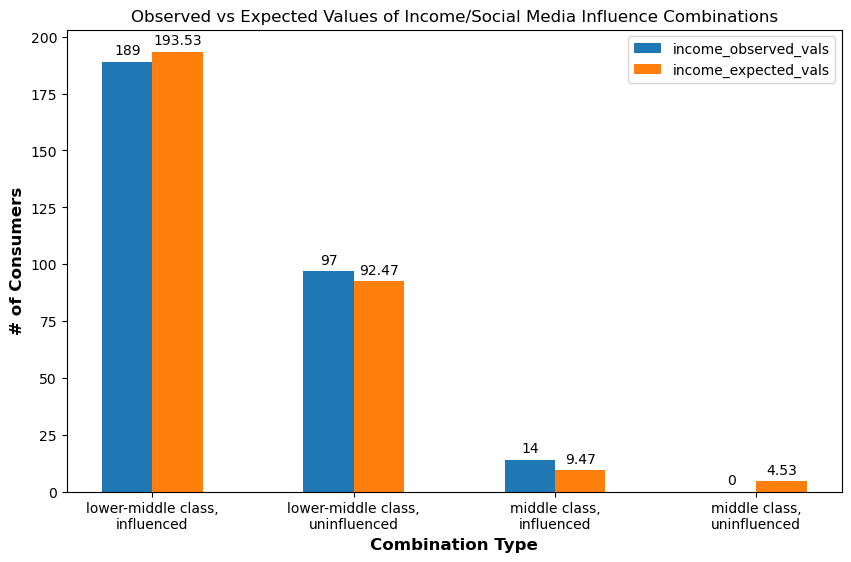

In [269]:
income_combos = ('lower-middle class, influenced', 'lower-middle class, uninfluenced', 'middle class, influenced', 'middle class, uninfluenced')
income_vals = {
    'income_observed_vals': (obs_income_data[0][0], obs_income_data[0][1], # female/influenced, male/influenced
                          obs_income_data[1][0], obs_income_data[1][1]), # female/uninfluenced, male/uninfluenced
    'income_expected_vals': (round(income_expected_freq[0][0], 2), round(income_expected_freq[0][1], 2), # female/influenced, male/influenced
                          round(income_expected_freq[1][0], 2), round(income_expected_freq[1][1], 2)) # female/uninfluenced, male/uninfluenced
}

x = np.arange(len(income_combos))  # the label locations
multiplier = 0

# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6)) 

# Add counts display for each bar
for attribute, measurement in income_vals.items():
    offset = barWidth * multiplier
    rects = plt.bar(x + offset, measurement, barWidth, label=attribute)
    plt.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Observed vs Expected Values of Income/Social Media Influence Combinations')
plt.xlabel('Combination Type', fontweight ='bold', fontsize = 12) 
plt.ylabel('# of Consumers', fontweight ='bold', fontsize = 12) 
plt.xticks([r + (barWidth / 2) for r in range(len(income_vals['income_observed_vals']))], 
           ['lower-middle class,\ninfluenced', 'lower-middle class,\nuninfluenced', 'middle class,\ninfluenced', 'middle class,\nuninfluenced'])

plt.legend()
plt.show()

__Insights from observed vs expected values__:
* Slightly fewer lower-middle class consumers than expected were influenced by social media for a purchase.
* Slightly more lower-middle class consumers than expected were not influenced by social media for a purchase.
* More middle class consumers than expected were influenced by social media for a purchase.
* Fewer middle class consumers than expected were not influecned by social media for a purchase.

### Factor 4: Education Level

* ``Null Hypothesis``: Education level and social media's influence on a purchase are independent.
* ``Alternative Hypothesis``: Education level and social media's influence on a purchase are not independent.

First I will loop through the dataset and determine what levels of education are present.

In [246]:
education_lvls = set()

for consumer in consumer_data:
    if consumer['Education Level'] not in education_lvls:
        education_lvls.add(consumer['Education Level'])
    else:
        pass

print(education_lvls)

{"Bachelor's", "Master's", 'High School', 'PhD'}


Now that we know the education levels, let's calculate the totals for every combination of education level and social media influence.

In [247]:
hs_influenced = 0
hs_uninfluenced = 0

bachelors_influenced = 0
bachelors_uninfluenced = 0

masters_influenced = 0
masters_uninfluenced = 0

phd_influenced = 0
phd_uninfluenced = 0

for consumer in consumer_data:
    if consumer['Purchase Decision'] == 'Yes':
        if consumer['Education Level'] == "Bachelor's":
            bachelors_influenced = bachelors_influenced + 1
        elif consumer['Education Level'] == "Master's":
            masters_influenced = masters_influenced + 1
        elif consumer['Education Level'] == "High School":
            hs_influenced = hs_influenced + 1
        else:
            phd_influenced = phd_influenced + 1
    else:
        if consumer['Education Level'] == "Bachelor's":
            bachelors_uninfluenced = bachelors_uninfluenced + 1
        elif consumer['Education Level'] == "Master's":
            masters_uninfluenced = masters_uninfluenced + 1
        elif consumer['Education Level'] == "High School":
            hs_uninfluenced = hs_uninfluenced + 1
        else:
            phd_uninfluenced = phd_uninfluenced + 1

# row totals for table display
edu_influenced_total = bachelors_influenced + masters_influenced + hs_influenced + phd_influenced
edu_uninfluenced_total = bachelors_uninfluenced + masters_uninfluenced + hs_uninfluenced + phd_uninfluenced

# column totals for table display
hs_total = hs_influenced + hs_uninfluenced
bachelors_total = bachelors_influenced + bachelors_uninfluenced
masters_total = masters_influenced + masters_uninfluenced
phd_total = phd_influenced + phd_uninfluenced

In [248]:
with open('observed_edu_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(("High School", "Bachelor's", "Master's", "PhD", "row totals"))
    
    writer.writerow(('influenced', hs_influenced, bachelors_influenced, masters_influenced, phd_influenced, edu_influenced_total))
    writer.writerow(('not influenced', hs_uninfluenced, bachelors_uninfluenced, masters_uninfluenced, phd_uninfluenced, edu_uninfluenced_total))
    writer.writerow(('column totals', hs_total, bachelors_total, masters_total, phd_total, consumer_total))

In [249]:
observed_edu_plot = pd.read_csv('observed_edu_table.csv')
observed_edu_plot

,High School,Bachelor's,Master's,PhD,row totals
influenced,2,165,88,31,286
not influenced,14,0,0,0,14
column totals,16,165,88,31,300


Both the high school/uninfluenced and PhD/uninfluenced combinations have expected values less than 5. This has created a accuracy vs precision dilemma that I will discuss below along with my decision on the matter:

<u>Dilemma</u>: If I choose to not include high school educated and phd educated consumers, I would have more precise measurements for the education levels still included in the analysis. However I would lose accuracy because I'd be losing over a sixth (47 consumers aka about 16%) of the total consumer population in the dataset. If I chose to include high school educated and phd educated consumers, I'd have a higher accuracy in my analysis. However, I would lose some precision since I'd have to combine education levels together to ensure all ``expected values`` are greater than 5. 

<u>Decision</u>: Faced with this dilemma, I reasoned I would rather my measurements be more correct and accurate rather than precise. So, I am combining education levels together to create the categories: ``high school to bachelor's`` and ``master's to PhD``.

With that decided, I will now revise my original education contingency table to reflect my adjustments.

In [250]:
# combination totals for revised edu table
hs_bachelors_influenced = hs_influenced + bachelors_influenced
hs_bachelors_uninfluenced = hs_uninfluenced + bachelors_uninfluenced

masters_phd_influenced = masters_influenced + phd_influenced
masters_phd_uninfluenced = masters_uninfluenced + phd_uninfluenced

# row totals for revised edu table remain the same as previous table
edu_influenced_total = bachelors_influenced + masters_influenced + hs_influenced + phd_influenced
edu_uninfluenced_total = bachelors_uninfluenced + masters_uninfluenced + hs_uninfluenced + phd_uninfluenced

# column totals for revised edu table 
hs_bachelors_total = hs_total + bachelors_total
masters_phd_total = masters_total + phd_total

In [251]:
with open('revised_observed_edu_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(("High School to Bachelor's", "Master's to PhD", "row totals"))
    
    writer.writerow(('influenced', hs_bachelors_influenced, masters_phd_influenced, edu_influenced_total))
    writer.writerow(('not influenced', hs_bachelors_uninfluenced, hs_bachelors_uninfluenced, edu_uninfluenced_total))
    writer.writerow(('column totals', hs_bachelors_total, masters_phd_total, consumer_total))

In [252]:
observed_edu_plot = pd.read_csv('revised_observed_edu_table.csv')
observed_edu_plot

,High School to Bachelor's,Master's to PhD,row totals
influenced,167,119,286
not influenced,14,14,14
column totals,181,119,300


Now that we have our revised education contingency table, I will use the chi-square test of independence using the ``chi2_contingency`` function from the ``scipy.stats`` package. 

In [253]:
# defining the table
obs_edu_data = [[hs_bachelors_influenced, masters_phd_influenced], # high school to bachelor's/influenced, master's to phd/influenced
                [hs_bachelors_uninfluenced, hs_bachelors_uninfluenced]] # high school to bachelor's/uninfluenced, master's to phd/uninfluenced

# income_test_stat = test statistic aka the chi-square value
# income_p_val = p-value of the test
# income_dof = degrees of freedom
# income_expected_freq = expected frequencies, based on the marginal sums of the table
edu_test_stat, edu_p_val, edu_dof, edu_expected_freq = chi2_contingency(obs_edu_data)

# display results
print('chi-square statistic: ' + str(edu_test_stat))
print('degrees of freedom: ' + str(edu_dof))
print('expected values:' + str(edu_expected_freq))

# interpret p-value
alpha = 0.05
print("p value is " + str(edu_p_val))
if edu_p_val <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

chi-square statistic: 0.4320060469584832
degrees of freedom: 1
expected values:[[164.85987261 121.14012739]
 [ 16.14012739  11.85987261]]
p value is 0.5110062497684047
Independent (H0 holds true)


__Chi-square test finding__:
Since the p-value is greater than our 0.05 alpha, the null hypothesis cannot be rejected, meaning that education level and social media's influence on a purchase are independent.

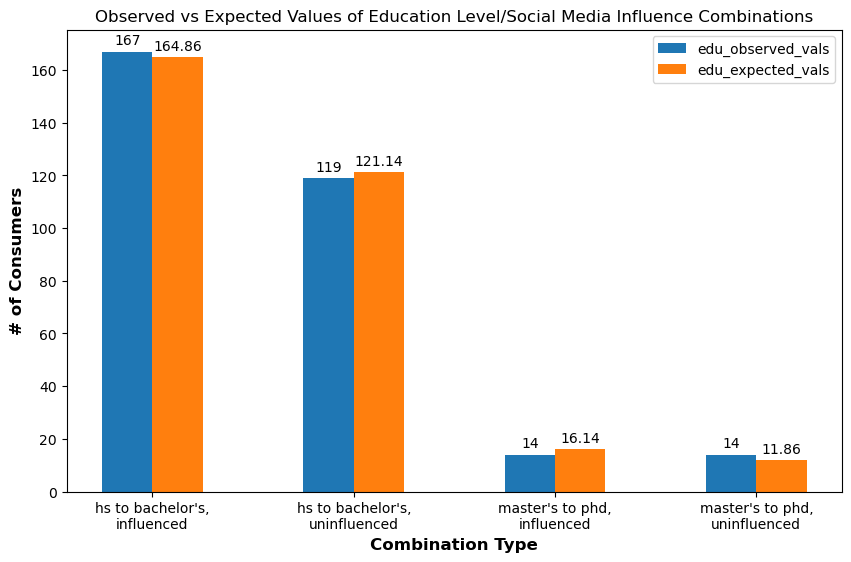

In [254]:
edu_combos = ("high school to bachelor's, influenced", "high school to bachelor's, uninfluenced",
                 "master's to phd, influenced'", "master's to phd, uninfluenced")
edu_vals = {
    'edu_observed_vals': (obs_edu_data[0][0], obs_edu_data[0][1], # high school to bachelor's/influenced, master's to phd/influenced
                          obs_edu_data[1][0], obs_edu_data[1][1]), # high school to bachelor's/uninfluenced, master's to phd/uninfluenced
    'edu_expected_vals': (round(edu_expected_freq[0][0], 2), round(edu_expected_freq[0][1], 2), # high school to bachelor's/influenced, master's to phd/influenced
                          round(edu_expected_freq[1][0], 2), round(edu_expected_freq[1][1], 2)) # high school to bachelor's/uninfluenced, master's to phd/uninfluenced
}

x = np.arange(len(edu_combos))  # the label locations
multiplier = 0

# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6)) 

# Add counts display for each bar
for attribute, measurement in edu_vals.items():
    offset = barWidth * multiplier
    rects = plt.bar(x + offset, measurement, barWidth, label=attribute)
    plt.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Observed vs Expected Values of Education Level/Social Media Influence Combinations')
plt.xlabel('Combination Type', fontweight ='bold', fontsize = 12) 
plt.ylabel('# of Consumers', fontweight ='bold', fontsize = 12) 
plt.xticks([r + (barWidth / 2) for r in range(len(edu_vals['edu_observed_vals']))], 
           ["hs to bachelor's,\ninfluenced", "hs to bachelor's,\nuninfluenced", "master's to phd,\ninfluenced", "master's to phd,\nuninfluenced"])

plt.legend()
plt.show()

__Insights from observed vs expected values__:
* Slightly more consumers than expected with a high school to bachelor's education level were influenced by social media for a purchase.
* Slightly less consumers than expected with a high school to bachelor's education level were not influenced by social media for a purchase.
* Slightly less consumers than expected with a master's or phd education level were influenced by social media for a purchase.
* Slightly more consumers than expected with a master's or phd education level were not influenced by social media for a purchase.

## RQ2: What social media platforms are the most used by consumers whose purchases were influenced by social media?

To try and answer this question, I will be analyzing the ``Social Media Platforms`` data column in the dataset.

First, let's loop through the dataset and determine what social media platforms consumers reported using. 

In [255]:
platforms_set = set()

for consumer in consumer_data:
    platforms = consumer['Social Media Platforms'].split(", ")

    if platforms[0] not in platforms_set:
        platforms_set.add(platforms[0])
    elif platforms[1] not in platforms_set:
        platforms_set.add(platforms[1])
    else:
        pass

print(platforms_set)

{'TikTok', 'Twitter', 'Snapchat', 'Pinterest', 'Facebook', 'LinkedIn', 'Instagram'}


I will now calculate the counts for each combination of social media platform and social media influence. 

In [256]:
def determine_platforms(curr_platforms, index, arr):
    if curr_platforms[index] == 'LinkedIn':
        arr[0] = arr[0] + 1
    elif curr_platforms[index] == 'Twitter':
        arr[1] = arr[1] + 1
    elif curr_platforms[index] == 'Instagram':
        arr[2] = arr[2] + 1
    elif curr_platforms[index] == 'Pinterest':
        arr[3] = arr[3] + 1
    elif curr_platforms[index] == 'Snapchat':
        arr[4] = arr[4] + 1
    elif curr_platforms[index] == 'Facebook':
        arr[5] = arr[5] + 1
    else:
        arr[6] = arr[6] + 1

In [257]:
platforms_influenced = [0, 0, 0, 0, 0, 0, 0] # linkedin = [0], twitter = [1], insta = [3], pinterest, snap, facebook, tiktok
platforms_uninfluenced = [0, 0, 0, 0, 0, 0, 0] # linkedin = [0], twitter = [1], insta = [3], pinterest, snap, facebook, tiktok

for consumer in consumer_data:
    curr_platforms = consumer['Social Media Platforms'].split(", ")
    
    if consumer['Purchase Decision'] == 'Yes':
        determine_platforms(curr_platforms, 0, platforms_influenced)
    else:
        determine_platforms(curr_platforms, 0, platforms_uninfluenced)

# row totals for table display
platforms_influenced_total = (platforms_influenced[0] + platforms_influenced[1] + platforms_influenced[2] + platforms_influenced[3] + 
                              platforms_influenced[4] + platforms_influenced[5] + platforms_influenced[6])

platforms_uninfluenced_total = (platforms_uninfluenced[0] + platforms_uninfluenced[1] + platforms_uninfluenced[2] + platforms_uninfluenced[3] + 
                              platforms_uninfluenced[4] + platforms_uninfluenced[5] + platforms_uninfluenced[6])

# column totals for table display
linkedin_total = platforms_influenced[0] + platforms_uninfluenced[0]
twitter_total = platforms_influenced[1] + platforms_uninfluenced[1]
insta_total = platforms_influenced[2] + platforms_uninfluenced[2]
pin_total = platforms_influenced[3] + platforms_uninfluenced[3]
snap_total = platforms_influenced[4] + platforms_uninfluenced[4]
fb_total = platforms_influenced[5] + platforms_uninfluenced[5]
tiktok_total = platforms_influenced[6] + platforms_uninfluenced[6]

Now that I have the counts for every cell, I will create a contingency table to visually display the values. I will also create a bar graph for better visualization of the results.

In [258]:
with open('observed_platforms_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(('LinkedIn', 'Twitter', 'Instagram', 'Pinterest', 'Snapchat', 'Facebook', 'TikTok', 'row totals'))
    
    writer.writerow(('influenced', platforms_influenced[0], platforms_influenced[1], platforms_influenced[2], platforms_influenced[3], 
                     platforms_influenced[4], platforms_influenced[5], platforms_influenced[6], platforms_influenced_total))
    writer.writerow(('not influenced',  platforms_uninfluenced[0], platforms_uninfluenced[1], platforms_uninfluenced[2], platforms_uninfluenced[3], 
                     platforms_uninfluenced[4], platforms_uninfluenced[5], platforms_uninfluenced[6], platforms_uninfluenced_total))
    writer.writerow(('column totals', linkedin_total, twitter_total, insta_total, pin_total, snap_total, fb_total, tiktok_total, consumer_total))

In [259]:
observed_edu_plot = pd.read_csv('observed_platforms_table.csv')
observed_edu_plot

,LinkedIn,Twitter,Instagram,Pinterest,Snapchat,Facebook,TikTok,row totals
influenced,18,28,98,23,15,61,43,286
not influenced,0,0,0,0,2,0,12,14
column totals,18,28,98,23,17,61,55,300


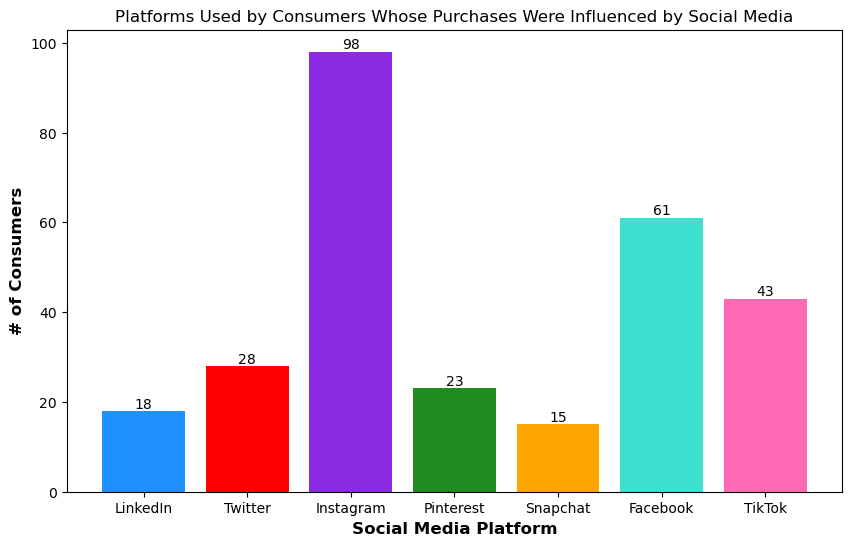

In [260]:
platform_names = ('LinkedIn', 'Twitter', 'Instagram', 'Pinterest', 'Snapchat', 'Facebook', 'TikTok')

df = pd.DataFrame({'height': platforms_influenced,
                   'bars': platform_names})

color = ['dodgerblue', 'red', 'blueviolet', 'forestgreen', 'orange', 'turquoise', 'hotpink']

# Create bars
plt.subplots(figsize =(10, 6))

bar_container = plt.bar(df['bars'], df['height'], color=color)
plt.bar_label(bar_container)

plt.title('Platforms Used by Consumers Whose Purchases Were Influenced by Social Media')
plt.xlabel('Social Media Platform', fontweight ='bold', fontsize = 12) 
plt.ylabel('# of Consumers', fontweight ='bold', fontsize = 12) 
# plt.xticks(rotation=35)

# Show graph
plt.show()

__Insights from Contingency Table & Bar Chart__:

The top three social media platforms used by consumers who reported a purchase being influenced by social media are as follows:
1. Instagram (98 consumers out of 286 aka ~34.27%)
2. Facebook (61 consumers out of 286 aka ~21.33%)
3. TikTok (43 consumers out of 286 aka ~15.03%)

## RQ3: Are there specific product categories where consumers are most likely to report that social media influenced their purchasing decisions?

To try and answer this question, I will be analyzing the ``Product Category`` data column in the dataset.

First, let's loop through the dataset and determine what product categories are present.

In [261]:
category_set = set()

for consumer in consumer_data:
    category = consumer['Product Category']
    
    if category not in category_set:
        category_set.add(category)
    else:
        pass

print(category_set)

{'Fitness', 'Beauty', 'N/A', 'Home Decor', 'Electronics', 'Food', 'Fashion'}


I will now calculate the counts for each combination of product category and social media influence on a purchase. 

In [262]:
def determine_category(category, arr):
    if category == 'Food':
        arr[0] = arr[0] + 1
    elif category == 'Fashion':
        arr[1] = arr[1] + 1
    elif category == 'Fitness':
        arr[2] = arr[2] + 1
    elif category == 'Beauty':
        arr[3] = arr[3] + 1
    elif category == 'Electronics':
        arr[4] = arr[4] + 1
    elif category == 'Home Decor':
        arr[5] = arr[5] + 1
    else:
        arr[6] = arr[6] + 1

In [263]:
categories_influenced = [0, 0, 0, 0, 0, 0, 0] # food = index 1, fashion = index 2, fitness = index 3, beauty, electronics, home decor, N/A
categories_uninfluenced = [0, 0, 0, 0, 0, 0, 0] # food = index 1, fashion = index 2, fitness = index 3, beauty, electronics, home decor, N/A

for consumer in consumer_data:
    if consumer['Purchase Decision'] == 'Yes':
        determine_category(consumer['Product Category'], categories_influenced)
    else: 
        determine_category(consumer['Product Category'], categories_uninfluenced)
        pass

# calculate row totals for table display
categories_influenced_total = (categories_influenced[0] + categories_influenced[1] + categories_influenced[2] + categories_influenced[3] + 
                              categories_influenced[4] + categories_influenced[5] + categories_influenced[6])
categories_uninfluenced_total = (categories_uninfluenced[0] + categories_uninfluenced[1] + categories_uninfluenced[2] + categories_uninfluenced[3] + 
                              categories_uninfluenced[4] + categories_uninfluenced[5] + categories_uninfluenced[6])

# calculate column totals for table display
food_total = categories_influenced[0] + categories_uninfluenced[0]
fashion_total = categories_influenced[1] + categories_uninfluenced[1]
fitness_total = categories_influenced[2] + categories_uninfluenced[2]
beauty_total = categories_influenced[3] + categories_uninfluenced[3]
electronics_total = categories_influenced[4] + categories_uninfluenced[4]
home_decor_total = categories_influenced[5] + categories_uninfluenced[5]
na_total = categories_influenced[6] + categories_uninfluenced[6]

In [264]:
with open('observed_categories_table.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(('Food', 'Fashion', 'Fitness', 'Beauty', 'Electronics', 'Home Decor', 'N/A', 'row totals'))
    
    writer.writerow(('influenced', categories_influenced[0], categories_influenced[1], categories_influenced[2], categories_influenced[3], 
                     categories_influenced[4], categories_influenced[5], categories_influenced[6], platforms_influenced_total))
    writer.writerow(('not influenced',  categories_uninfluenced[0], categories_uninfluenced[1], categories_uninfluenced[2], categories_uninfluenced[3], 
                     categories_uninfluenced[4], categories_uninfluenced[5], categories_uninfluenced[6], platforms_uninfluenced_total))
    writer.writerow(('column totals', food_total, fashion_total, fitness_total, beauty_total, electronics_total, home_decor_total, na_total, consumer_total))

In [265]:
observed_edu_plot = pd.read_csv('observed_categories_table.csv')
observed_edu_plot

,Food,Fashion,Fitness,Beauty,Electronics,Home Decor,N/A,row totals
influenced,1,50,40,50,79,65,1,286
not influenced,0,0,0,0,0,0,14,14
column totals,1,50,40,50,79,65,15,300


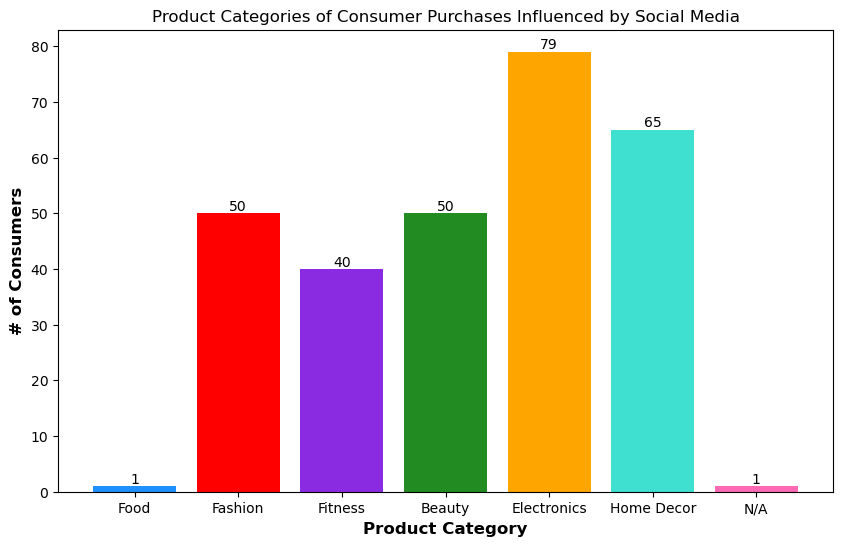

In [266]:
category_names = ('Food', 'Fashion', 'Fitness', 'Beauty', 'Electronics', 'Home Decor', 'N/A')

df = pd.DataFrame({'height': categories_influenced,
                   'bars': category_names})

color = ['dodgerblue', 'red', 'blueviolet', 'forestgreen', 'orange', 'turquoise', 'hotpink']

# Create bars
plt.subplots(figsize =(10, 6))

bar_container = plt.bar(df['bars'], df['height'], color=color)
plt.bar_label(bar_container)

plt.title('Product Categories of Consumer Purchases Influenced by Social Media')
plt.xlabel('Product Category', fontweight ='bold', fontsize = 12) 
plt.ylabel('# of Consumers', fontweight ='bold', fontsize = 12) 
# plt.xticks(rotation=35)

# Show graph
plt.show()

__Insights from contingency table and bar chart__:

The top four product categories of consumers whose purchase was influenced by social media are as follows:
1. Electronics (79 consumers out of 286 aka ~27.62%)
2. Home Decor (65 consumers out of 286 aka ~22.72%)
3. Fasion and Beauty (both 50 consumers out of 286 aka ~17.48%)